In [3]:
import requests
import networkx as nx
import numpy as np
import math
import random

from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objs as go

%matplotlib inline

In [4]:
id = 63399107
access_token = 'ba750c0fba750c0fba750c0ff2ba1f5397bba75ba750c0fe6b885ae3f36b2fe81010b1d'

In [5]:
res_users = requests.get('https://api.vk.com/method/users.get?user_ids={0}&access_token={1}&v=5.95'.format(id, access_token))
my_id = res_users.json()['response'][0]['id']

In [6]:
def ids_friends(user_ids):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}&access_token={}&v=5.95'
    json_response = requests.get(friends_url.format(user_ids, access_token)).json()
    if json_response.get('Error'):
        print(json_response.get('Error'))
        return list()
    return json_response

In [7]:
friend_ids = ids_friends(id)
friend_ids['response']['items'][0]

friends_of_friend = ids_friends(friend_ids['response']['items'][0])
friends_of_friend['response']['items'][0]

239993

In [8]:
graph = {}

friends = ids_friends(my_id)['response']['items']
graph[my_id] = friends

for f in friends:
    friends_of_friend = ids_friends(f)
    if 'response' in friends_of_friend:
        
        graph[f] = friends_of_friend['response']['items']



In [9]:
team = [63399107, 32703581, 86991442]

In [10]:
friends_of_team = set()
for member in team:
    friends_of_team.add(member)
    for person in graph[member]:
        friends_of_team.add(person)

In [11]:
graph_final = {}
for person in graph:
    cur_friends = graph[person]
    new_friends = []
    for item in cur_friends:
        if item in friends_of_team:
            new_friends.append(item)
    graph_final[person] = new_friends

In [12]:
graph_finfin = {}
for person in friends_of_team:
    if person in graph_final.keys():
        graph_finfin[person] = graph_final[person]
    else:
        tmp = []
        for item in graph_final:
            if person in graph_final[item]:
                tmp.append(item)
        graph_finfin[person] = tmp

In [13]:
def make_nx_graph(graph):
    g = nx.Graph()
    for i in graph:
        for j in graph[i]:
            if not (g.has_edge(j, i) or g.has_edge(i, j)):
                g.add_edge(i, j)
    return g

In [14]:
def F_att(a, b, K):
    coeff = -math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)/K
    return [coeff * a[0] - b[0], coeff * a[1] - b[1]]

In [15]:
def F_rep(a, b, K):
    coeff = K**2 / ((a[0] - b[0])**2 + (a[1] - b[1])**2)
    return [coeff * a[0] - b[0], coeff * a[1] - b[1]]

In [16]:
def rand_layout(graph):
    initial_coords = {}
    for vert in graph.keys():
        initial_coords[vert] = [random.uniform(0, 1000), random.uniform(0, 1000)]
    return initial_coords

In [17]:
def force_directed_alg(graph, init_step, tol, K):
    converged = False
    step = init_step
    x = rand_layout(graph)
    cnt = 1
    while (converged == False):
        x0 = deepcopy(x)
        for vert in graph.keys():
            f = [0, 0]
            for neighb in graph[vert]:
                f[0] += F_att(x[vert], x[neighb], K)[0]
                f[1] += F_att(x[vert], x[neighb], K)[1]
            for other_vert in graph.keys():
                if other_vert != vert:
                    f[0] += F_rep(x[vert], x[neighb], K)[0]
                    f[1] += F_rep(x[vert], x[neighb], K)[1]
            x[vert][0] += step * f[0]/(math.sqrt(f[0] ** 2 + f[1] ** 2))
            x[vert][1] += step * f[1]/(math.sqrt(f[0] ** 2 + f[1] ** 2))
        step = init_step / cnt ** (1/2)
        cnt += 1
        sum_norm = 0
        for vert in graph.keys():
            sum_norm += math.sqrt((x[vert][0] - x0[vert][0]) ** 2 + (x[vert][1] - x0[vert][1]) ** 2)
        avg_norm = sum_norm / len(graph.keys())
        if avg_norm < tol * K:
            converged = True
    return x

In [26]:
def draw_graph(graph, init_step, tol, K, with_labels_param, width_param, alpha_param, node_color_param):
    pos = force_directed_alg(graph, init_step, tol, K)
    graph_nx = make_nx_graph(graph)
    p = {}
    for item in graph:
        p[item] = len(graph[item])
    plt.figure(figsize=(15, 15))
    nx.draw_networkx(graph_nx, pos, 
                 with_labels=with_labels_param,  
                 width=width_param,
                 alpha=alpha_param,
                 nodelist=list(p.keys()),
                 node_size=list(p.values()),
                 node_color=node_color_param)
    min_x = float('inf')
    min_y = float('inf')
    max_x = -float('inf')
    max_y = -float('inf')
    for item in pos:
        if pos[item][0] > max_x:
            max_x = pos[item][0]
        if pos[item][0] < min_x:
            min_x = pos[item][0]
        if pos[item][1] > max_y:
            max_y = pos[item][1]
        if pos[item][1] < min_y:
            min_y = pos[item][1]
    plt.xlim(min_x - 25, max_x + 25)
    plt.ylim(min_y - 25, max_y + 25)
    plt.show()

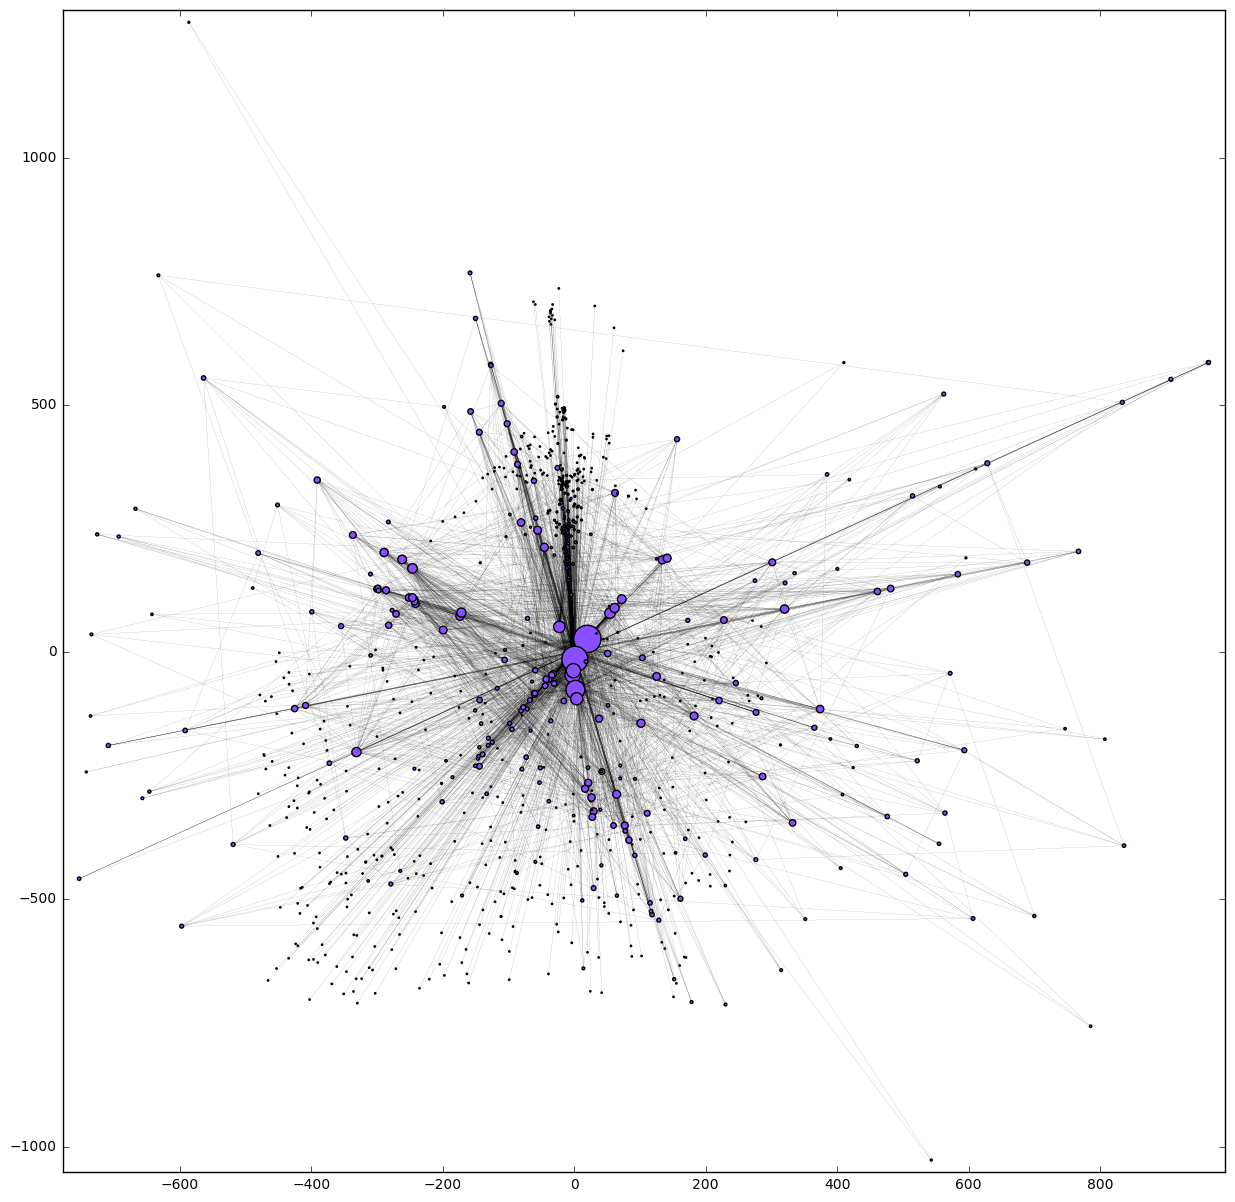

In [27]:
draw_graph(graph_finfin, 100, 1.7, 10, False, 0.055, 1, "#874fff")

In [33]:
graph_nx = make_nx_graph(graph_finfin)

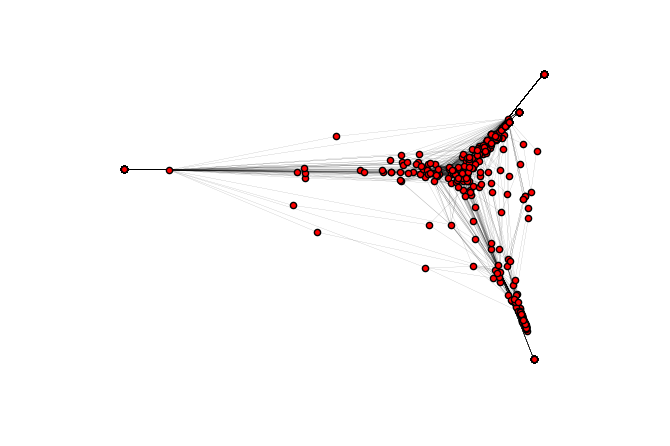

In [34]:
nx.draw_spectral(graph_nx, node_size=20, width=0.055)

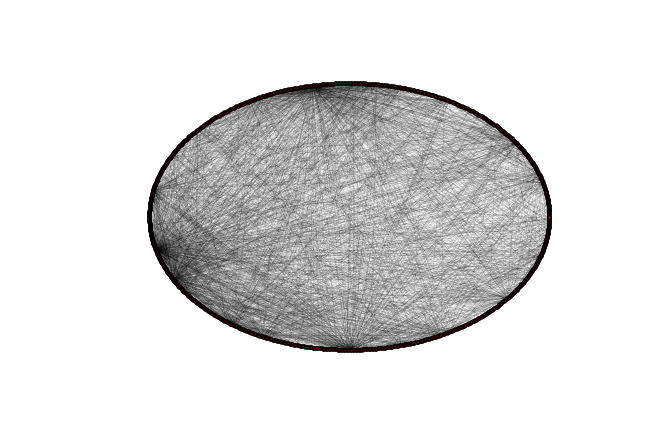

In [35]:
nx.draw_circular(graph_nx, node_size=5, width=0.05)

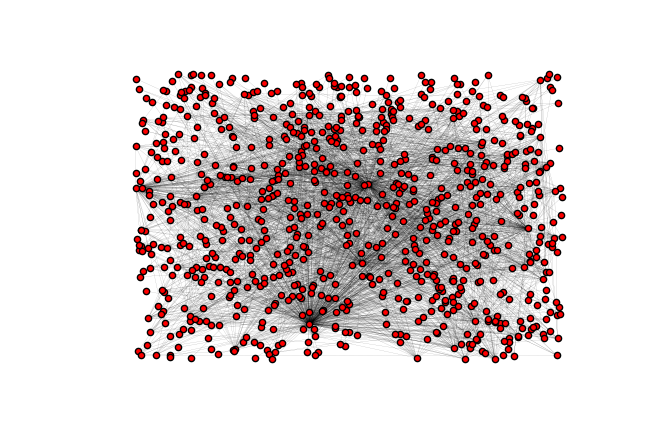

In [36]:
nx.draw_random(graph_nx, node_size=20, width=0.05)

In [29]:
graph_2 = {}
for member in team:
    graph_2[member] = graph_finfin[member]
graph_2_fin = {}
for person in friends_of_team:
    if person in graph_2.keys():
        graph_2_fin[person] = graph_2[person]
    else:
        tmp = []
        for item in graph_2:
            if person in graph_2[item]:
                tmp.append(item)
        graph_2_fin[person] = tmp

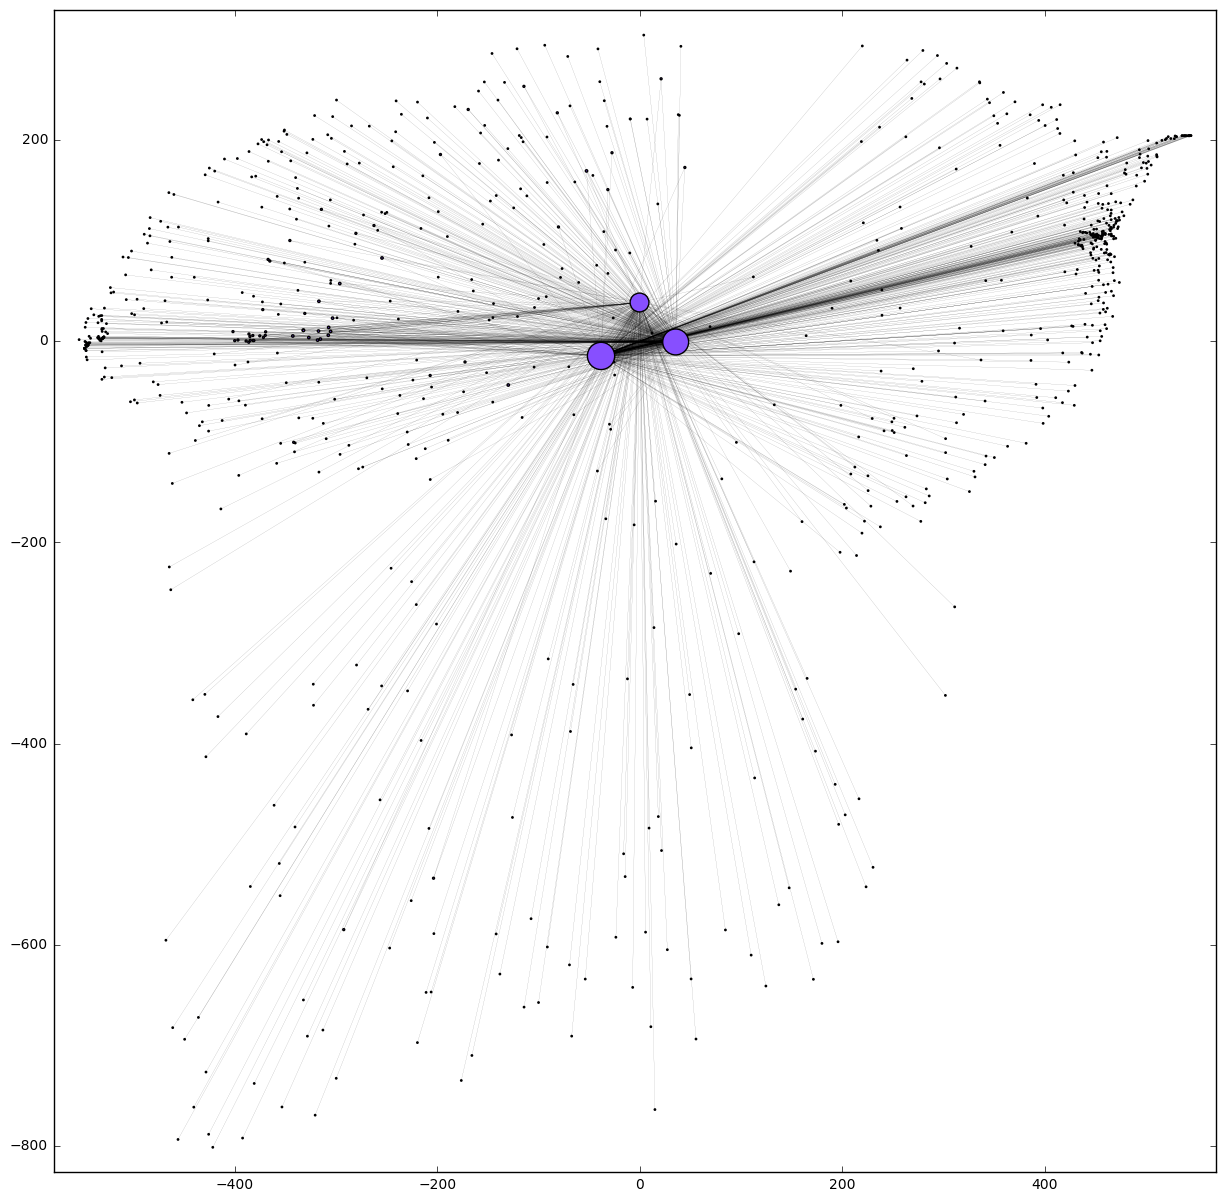

In [30]:
draw_graph(graph_2_fin, 100, 1.7, 10, False, 0.055, 1, "#874fff")

In [37]:
graph_2_nx = make_nx_graph(graph_2_fin)

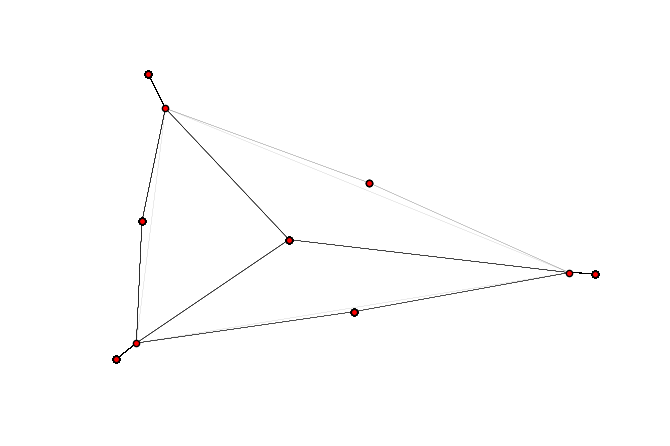

In [38]:
nx.draw_spectral(graph_2_nx, node_size=20, width=0.055)

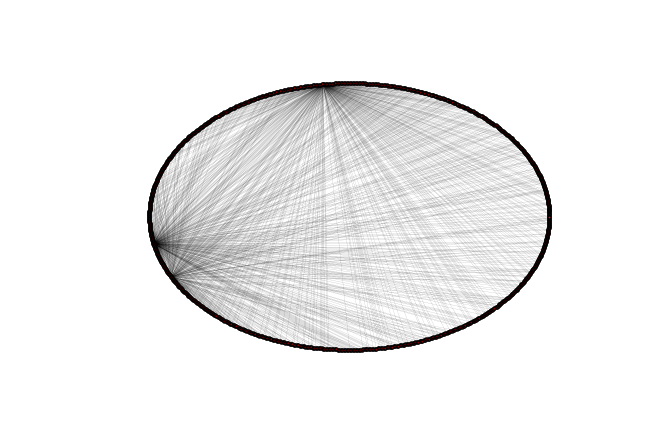

In [39]:
nx.draw_circular(graph_2_nx, node_size=5, width=0.05)

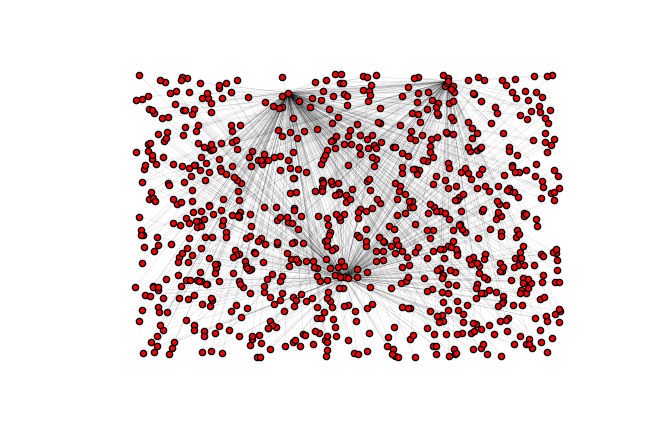

In [40]:
nx.draw_random(graph_2_nx, node_size=20, width=0.05)

In [41]:
graph_3 = {}
tops = set()
for item in graph_finfin:
    if len(graph_finfin[item]) > 50:
        tops.add(item)
for item in graph_finfin:
    graph_3[item] = []
    for friend in graph_finfin[item]:
        if friend in tops:
            graph_3[item].append(friend)

In [42]:
graph_3_nx = make_nx_graph(graph_3)

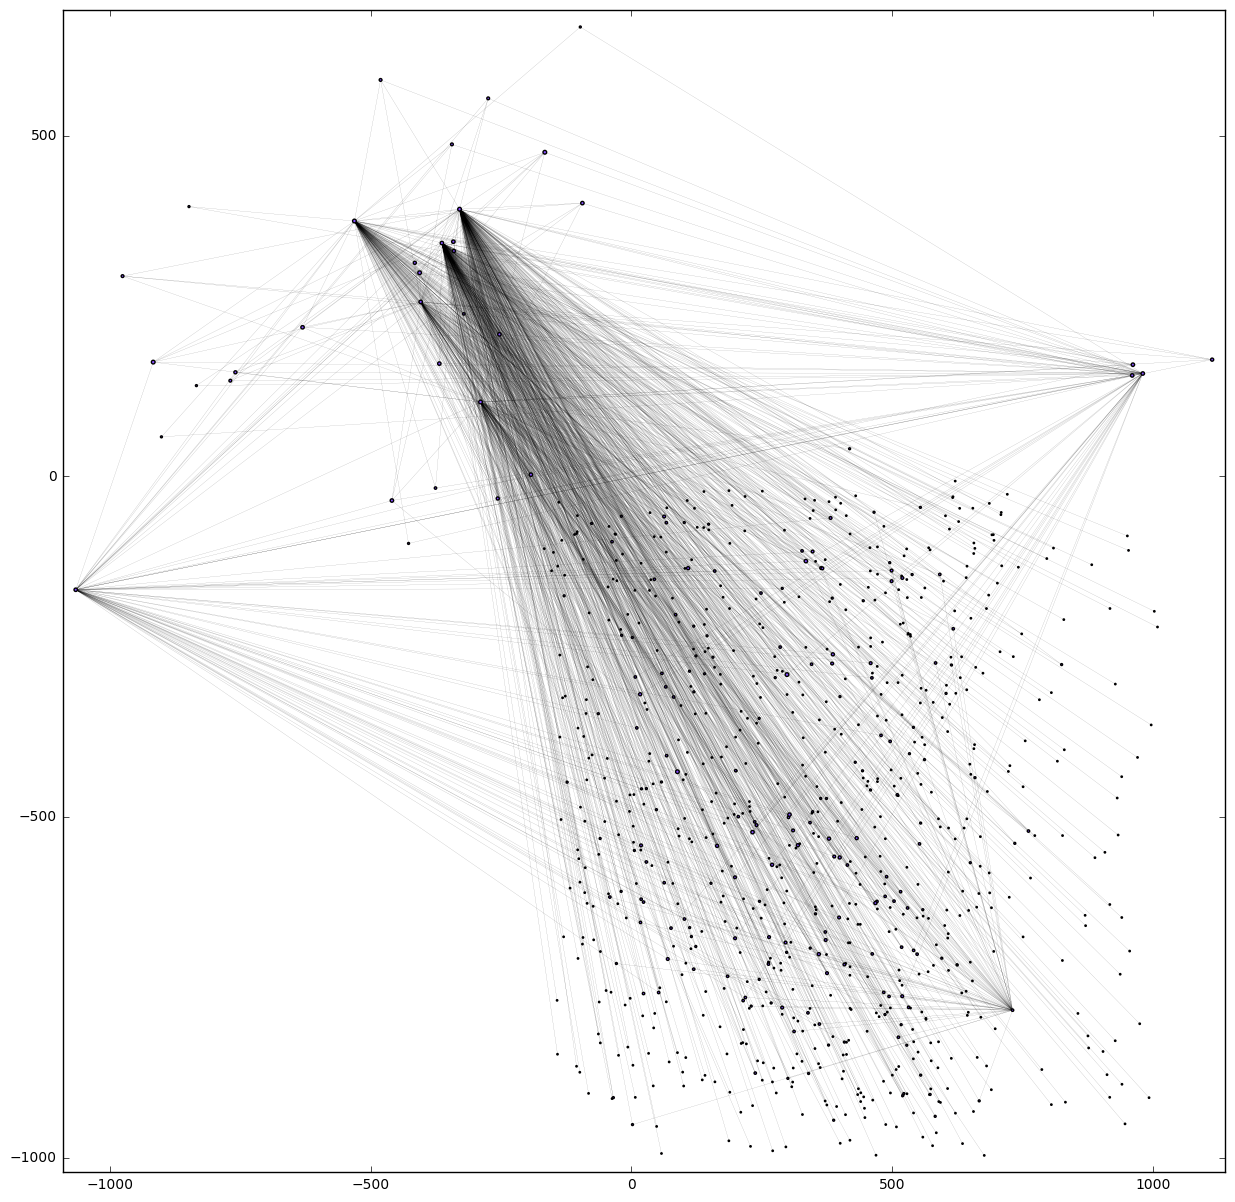

In [44]:
draw_graph(graph_3, 100, 1.7, 10, False, 0.055, 1, "#874fff")

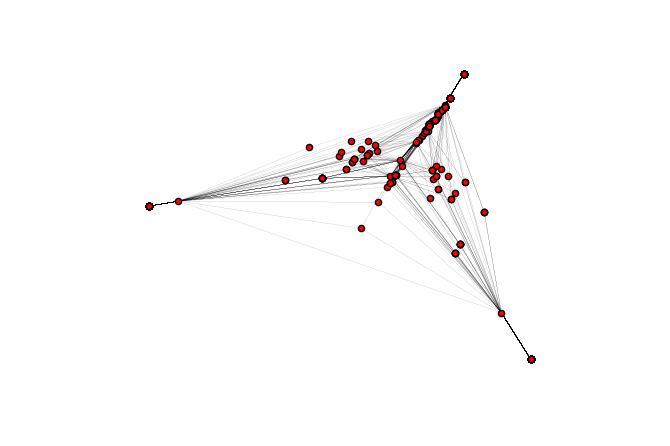

In [45]:
nx.draw_spectral(graph_3_nx, node_size=20, width=0.055)

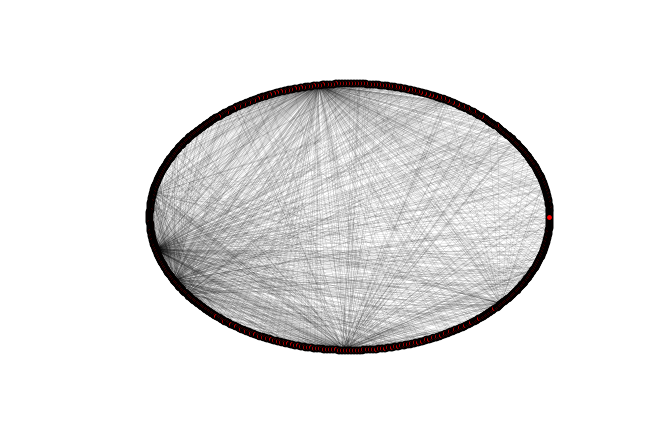

In [46]:
nx.draw_circular(graph_3_nx, node_size=20, width=0.055)

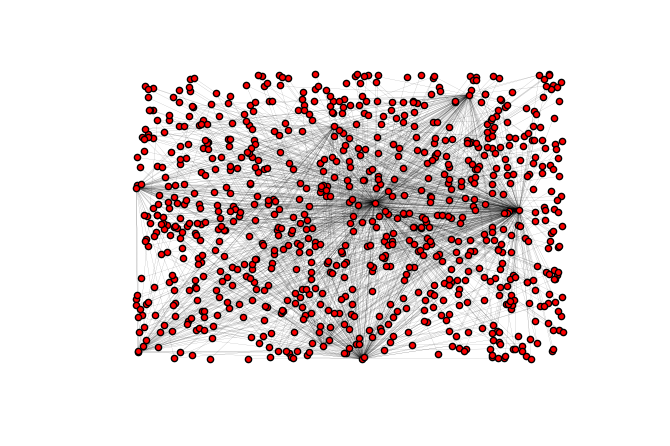

In [47]:
nx.draw_random(graph_3_nx, node_size=20, width=0.055)